In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from cycler import cycler
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize':(10,10), 
            'lines.markersize':15, 
            "animation.embed_limit":100})
sns.mpl.rc("axes", prop_cycle=cycler('color',
        ['#E24A33', '#348ABD', '#988ED5', 
         '#777777', '#FBC15E', '#8EBA42',
         '#FFB5B8']))
sns.set_style('darkgrid',{'axes.facecolor':"0.8"})

## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import metrics

## for markers
import itertools
marker = itertools.cycle(('o', 'v', '^','D', '+', 'X', '<', '>')) 
colors =  itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777', 
                           '#FBC15E', '#8EBA42', '#FFB5B8'))

## don't show warning
import warnings
warnings.filterwarnings('ignore')

# import the Escal Tools
import os, sys
#sys.path.append(os.path.expanduser("~/project/Simulation/All-Atomic/analysis/python"))
import EscalTools as et
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## The data per frames
skip = 5

## for scaling
kmax = 100

## for smooth data
smooth = et.segment.medoid
step   = 100
width = 200

### for matrix method
similar = et.dist.cosin

### number of clusters
score = pd.DataFrame({'ncluster':np.arange(2,30)})

### evalute method
evalute = metrics.calinski_harabasz_score # et.evalute.cluster

In [3]:
## the data directory
fpref = os.path.expanduser('~') + "/data/gromacs/"
fpref += "data.UBQ/1ubq/"
fpref += "unfolding/"
fpref += "550-"

# RMSD

In [4]:
rms = pd.DataFrame(np.loadtxt(fpref+"CaRMS.xvg", comments=["@","#"],
                    dtype = {'names': ("Time (ps)", "RMSD (nm)"),
                                 'formats': ('f', 'f')})) 
rms = rms.loc[1::skip,:]
#rms["RMSD (nm)"] = np.log(rms["RMSD (nm)"])

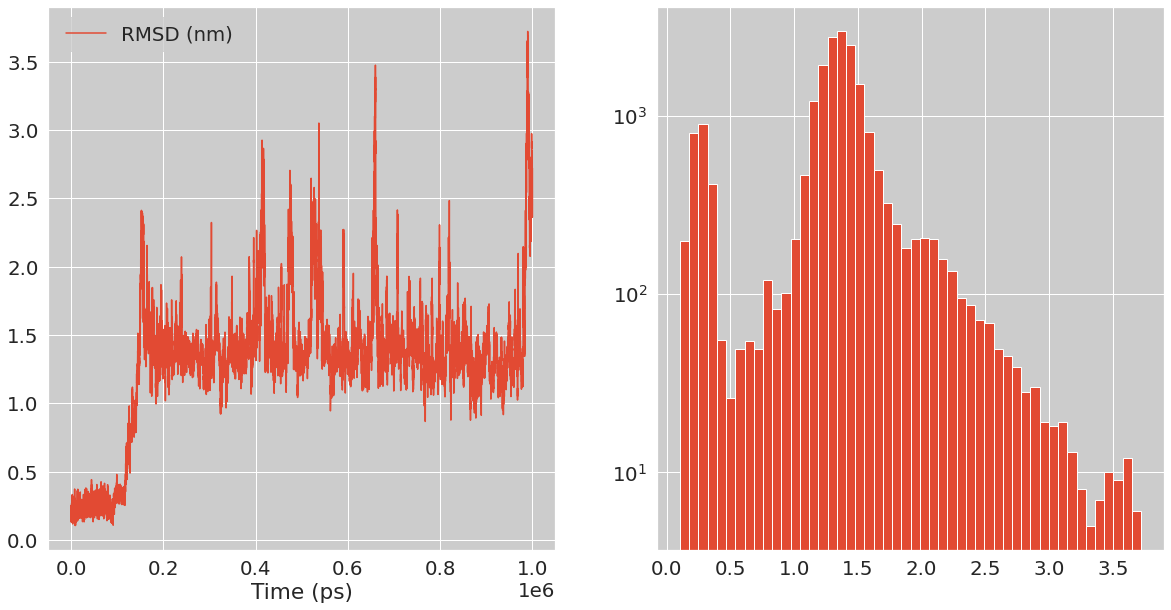

In [5]:
plt.figure(12,figsize=(20,10))
ax = plt.subplot(121)
rms.plot("Time (ps)", "RMSD (nm)", ax=ax)
ax = plt.subplot(122)
hist = ax.hist(rms["RMSD (nm)"], bins=50)
plt.yscale('log')

# Clustering by Raw Data

In [6]:
#read X data
X0 = et.feature.dih2X(pd.DataFrame(np.loadtxt(fpref+"rama.xvg", comments=["@","#"],
                        dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                 'formats': ('f', 'f', 'S7')}))) 
# normaliztion
X0 = X0.loc[1::skip,:].reset_index(drop=True)
X0 = np.array(X0)
print("The shape of X0 is: ", X0.shape)

The shape of X0 is:  (20000, 296)


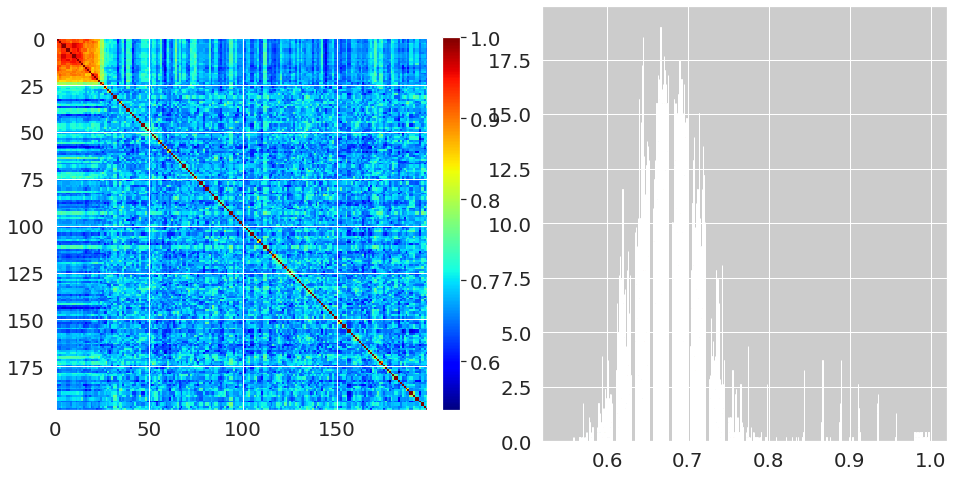

In [7]:
## get the samples
X0s = smooth(X0, step, width)

## set distance function and get distance
Smat0  = similar(X0s)
fig, axs = plt.subplots(1,2, figsize=(16,8)) 
et.plot.implot(Smat0, axs[0])
hist = axs[1].hist(Smat0, bins=20, density=True)

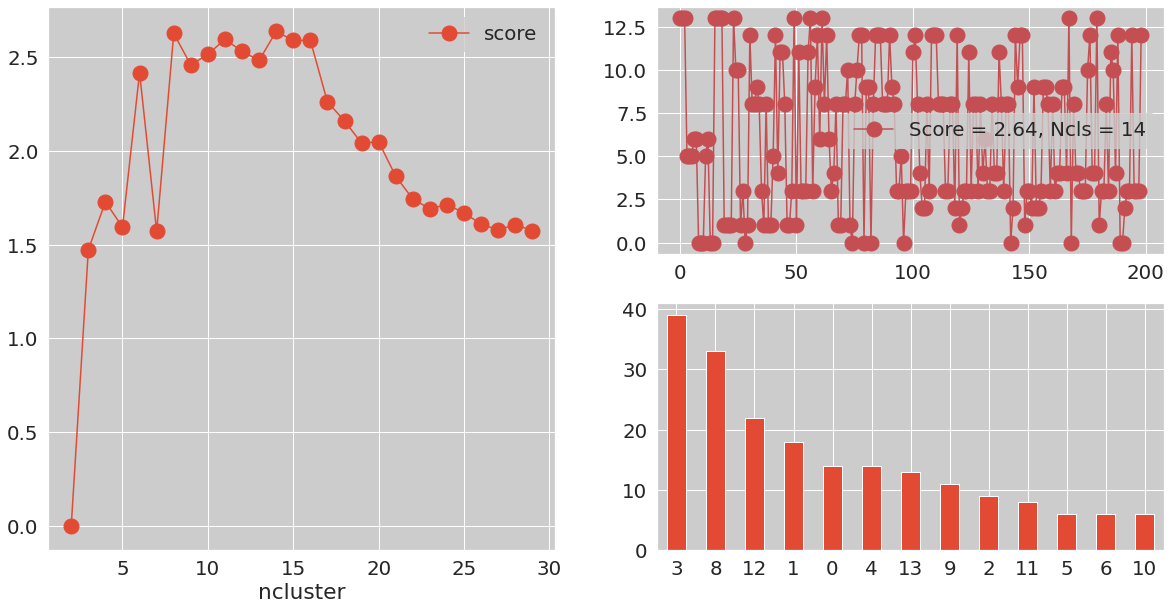

In [8]:
#input data
theXS = X0s

def testKM(n):
    cl = KMedoids(n_clusters=n).fit_predict(theXS)
    return  np.max(cl) > 0 and evalute(theXS, cl) or 0

score['score'] = score['ncluster'].apply(testKM)
idxPeak = score['score'].idxmax();
ncls = score.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(theXS)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute(theXS, cl), ncls)

### plot data
et.plot.clplot(score.set_index("ncluster"), cl, lab)

# Energy scaled data

In [9]:
### read the energy
eng = pd.DataFrame(np.loadtxt(fpref+"potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))
### base frequence in MHz
## 1000,000 for M and P, and 2 for even extension
ufreq = 500000*skip/eng.loc[len(eng)-1, "time"]
print("The base frequence is {:.4f} MHz".format(ufreq))

E0 = np.array(eng.loc[1::skip, 'energy'])
print("The shape of Energy is: ", E0.shape)

The base frequence is 2.5000 MHz
The shape of Energy is:  (20000,)


In [10]:
## do FFT rescaling
scl = et.scaling.Efft(X0, E0)

Text(24.9, 0.9322015753077759, '#15 (35.0 MHz)\nQMC = 0.95')

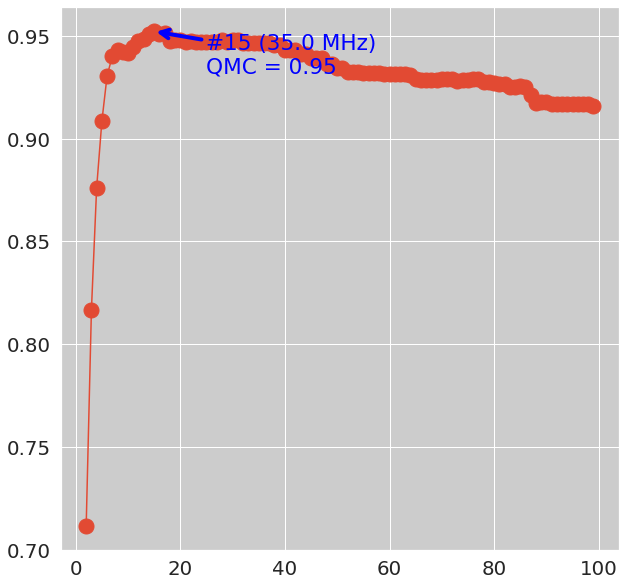

In [11]:
## plot the multiple correlation coefficient
qmc = scl.check(kmax)
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy    = (qmc['KappaMax'], qmc['qmcMax'])
xytxt = [xy[0]+0.1*np.max(qmc['list'][:,0]), xy[1]-0.02]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

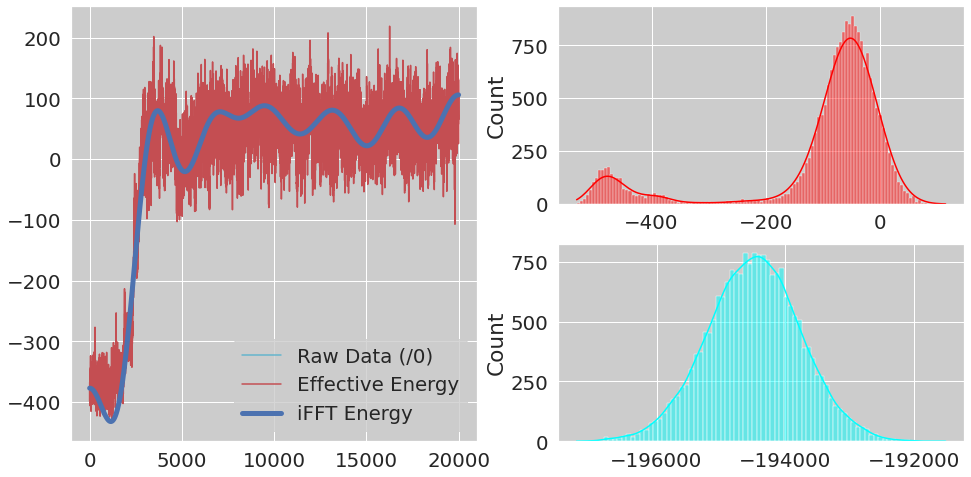

In [12]:
## plot the effective energy
rescl = scl.rescale(qmc['KappaMax'])
et.plot.efplot(E0, rescl['Ef'], np.dot(X0, rescl['A']))

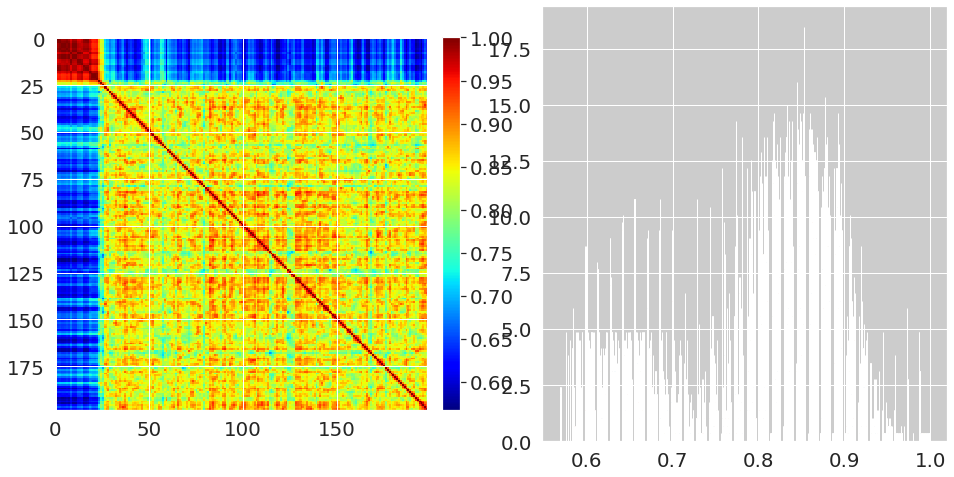

In [13]:
Xys = et.segment.median(rescl['X'], step, width)
Smaty  = similar(Xys)

## set distance function and get distance
fig, axs = plt.subplots(1,2, figsize=(16,8)) 
et.plot.implot(Smaty, axs[0])
hist = axs[1].hist(Smaty, bins=30, density=True)

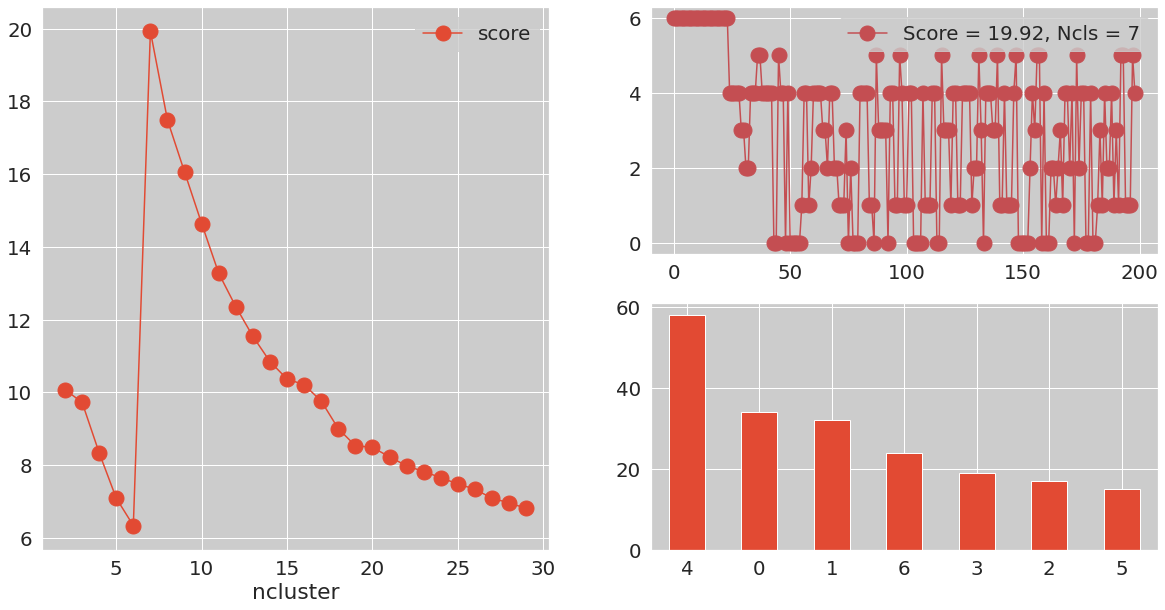

In [14]:
#input data
theXS = Xys

def testKM(n):
    cl = KMedoids(n_clusters=n).fit_predict(theXS)
    return  np.max(cl) > 0 and evalute(theXS, cl) or 0

score['score'] = score['ncluster'].apply(testKM)
idxPeak = score['score'].idxmax();
ncls = score.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(theXS)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute(theXS, cl), ncls)

### plot data
et.plot.clplot(score.set_index("ncluster"), cl, lab)